In [ ]:
# Example 09: Characterising the electrophysiology data of a single insertion
#In this example we show how to

#1. Load in spikesorting data for a single insertion data
#2. Evaluate the number of good clusters
#3. Find the location of good clusters in the brain
#4. Compute the firing rate of each cluster
#5. Plot the firing rate of good clusters alongside their brain location

In [2]:
# 1. Load in spikesorting data for pid
from brainbox.io.one import SpikeSortingLoader
from one.api import ONE
import numpy as np
one = ONE()

eid='288bfbf3-3700-4abe-b6e4-130b5c541e61'
pid='05ec6af9-6c83-422d-91a3-ba815fa65e92'

ssl = SpikeSortingLoader(one=one, pid=pid)
spikes, clusters, channels = ssl.load_spike_sorting()
clusters = ssl.merge_clusters(spikes, clusters, channels)


In [3]:
# 2. Evaluate the number of good clusters
# The spikesortingloader loads data for all clusters (both mua and good) detected by the spikesorter.
# We can restrict to only the good clusters by finding the clusters with a label of 1
good_cluster_idx = clusters['label'] == 1
clusters_good = {key:val[good_cluster_idx] for key, val in clusters.items()}

all_clusters = clusters['label'].shape
good_clusters = clusters_good['label'].shape
print(f'Total no. of clusters: {all_clusters}')
print(f'Number of good clusters: {good_clusters}')

Total no. of clusters: (516,)
Number of good clusters: (19,)


In [4]:
# 3. Find the location of clusters in brain
# The location of the clusters can be found in the atlas_id (Allen CCF ids) or acronym attributes of the clusters object
acronyms = clusters_good['acronym']
unique_acronyms, count = np.unique(acronyms, return_counts=True)
for a, c in zip(unique_acronyms, count):
  print(f'{a}: {c}')

ANcr2: 1
CB: 3
PRM: 4
SPVC: 1
SPVI: 6
arb: 1
sptV: 3


In [5]:
# 4. Compute the firing rate of each cluster
# The firing rate of each cluster can be found in the firing rate atrribute of the clusters object
firing_rate = clusters_good['firing_rate']

# To show the interaction between the clusters and the spikes object we will show how you can compute
# the firing rate from the data

# To compute the firing rate we first need to compute the number of spikes detected for each cluster
n_spikes = np.empty((clusters_good['cluster_id'].shape))
# Loop over the cluster ids
for i, c in enumerate(clusters_good['cluster_id']):
  # Find location where each cluster id is found in the spikes objects and get the sum 
  cidx = np.sum(spikes['clusters'] == c)
  n_spikes[i] = cidx

# To compute the firing rate we can divide the spike count by the total duration of the recording
duration = np.max(spikes['times']) - np.min(spikes['times'])
firing_rate_from_spikes = n_spikes / duration

# Make sure that the values for firing rates are the same
np.array_equal(firing_rate_from_spikes, firing_rate)

True

C:\Users\Karolina\AppData\Local\Temp\ipykernel_12908\861508613.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  mapper = cm.ScalarMappable(norm=norm, cmap=cm.get_cmap('hot'))
C:\Users\Karolina\AppData\Local\Temp\ipykernel_12908\861508613.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  mapper = cm.ScalarMappable(norm=norm, cmap=cm.get_cmap('hot'))


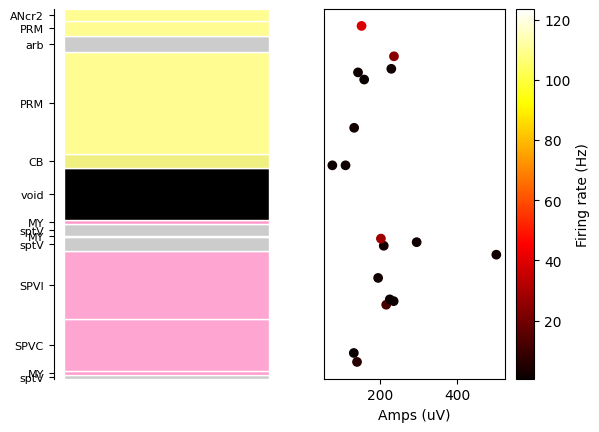

In [6]:
# 5. Plot firing rate and brain locations
import matplotlib.pyplot as plt
from matplotlib import cm, colors
from brainbox.ephys_plots import plot_brain_regions
clusters_good.keys()

norm = colors.Normalize(vmin=np.min(firing_rate), vmax=np.max(firing_rate), clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.get_cmap('hot'))
firing_rate_cols = mapper.to_rgba(firing_rate)

fig, axs = plt.subplots(1, 2)
# Plot the brain regions through which the channels on the insertion pass
plot_brain_regions(channels['atlas_id'], channel_depths=channels['axial_um'], ax=axs[0])
# Plot scatter plot of cluster depths vs cluster amp with firing rate encoded in colour
# Map firing rate values to colours
norm = colors.Normalize(vmin=np.min(firing_rate), vmax=np.max(firing_rate), clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.get_cmap('hot'))
firing_rate_cols = mapper.to_rgba(firing_rate)
axs[1].scatter(clusters_good['amp_median'] * 1e6, clusters_good['depths'], c=firing_rate_cols)
axs[1].set_xlabel('Amps (uV)')
axs[1].get_yaxis().set_visible(False)
# Add colorbar
cbar = fig.colorbar(mapper, ax=axs[1])
cbar.set_label('Firing rate (Hz)')